In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import torch
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from rxn_yield_context.evaluate_model.eval_utils import MultiTask_Evaluator
from rxn_yield_context.train_multilabel.data_utils import ContextDatapoint
from rxn_yield_context.train_multilabel.args_train import TrainArgs_rxn

data_path = "../data/reaxys_output/For_second_part_model/Splitted_second_train_labels_processed.txt"
reagent_path = "../data/reaxys_output/label_processed/class_names_reagent_labels_processed.pkl"
solvent_path = "../data/reaxys_output/label_processed/class_names_solvent_labels_processed.pkl"
model_path = "../save_models/test_10R_first_local_10/multitask_model_epoch-80.checkpoint"
random.seed(11)

def remove_duplicated_records(records):
    return '; '.join(list(dict.fromkeys(records.split('; '))))

def sort_out_data(data):
    data = [line.strip('\n').split('\t') for line in data]
    sorted_data = []
    rxn_id = ''
    j = -1
    for i in range(len(data)):
        if rxn_id != data[i][0]:
            j += 1
            sorted_data.append([data[i][0], data[i][1], data[i][2], []])
            y_ = data[i][3]; r_ = remove_duplicated_records(data[i][4]);
            s_ = remove_duplicated_records(data[i][5]); t_ = data[i][6];
            sorted_data[j][3].append((y_, r_, s_, t_))
            rxn_id = data[i][0]
        else:
            if (r_ == remove_duplicated_records(data[i][4])) & (s_ == remove_duplicated_records(data[i][5])):
                pass
            else:
                y_ = data[i][3]; r_ = remove_duplicated_records(data[i][4]);
                s_ = remove_duplicated_records(data[i][5]); t_ = data[i][6];
                sorted_data[j][3].append((y_, r_, s_, t_))
    return sorted_data

In [77]:
with open(data_path, 'r',encoding='UTF-8') as f:
    data = f.readlines()
data = sort_out_data(data)

def get_classes(path):
    f = open(path, 'rb')
    dict_ = pickle.load(f)
    f.close()
    classes = sorted(dict_.items(), key=lambda d: d[1],reverse=True)
    classes = [(x,y) for x,y in classes]
    return classes

reagent_class = get_classes(reagent_path)
solvent_class = get_classes(solvent_path)
Evaluator = MultiTask_Evaluator(solvent_class, reagent_class, cutoff_solv = 0.15, cutoff_reag = 0.25) # for hard negative sampling
Evaluator.load_model(model_path, torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [80]:
for l in data:
    if l[0] == '9079015':
        break
print(l)
args = TrainArgs_rxn()
test_context = ContextDatapoint(l[1], l[2], l[3], args, solvent_class, reagent_class)
random.seed(20)
test_context.cutoff_augmentation(2, Evaluator)
print(test_context.fake_solv, test_context.fake_reag)

['9079015', 'CC1=CC=C(Cl)C=C1.NC1CCCCC1', 'CC1=CC=C(NC2CCCCC2)C=C1', [('96', 'potassium phosphate', 'dimethyl sulfoxide', '80.0'), ('93', 'potassium tert-butylate', '1,4-dioxane', '110.0'), ('92', 'potassium 2-methylbutan-2-olate', '1,2-dimethoxyethane', '80.0'), ('88', "(N,N'-diarylimidazol-2-ylidene)-based palladacycle; sodium t-butanolate", '1,4-dioxane', '70.0'), ('86', 'sodium t-butanolate', '1,4-dioxane', '110.0'), ('83', 'potassium phosphate; copper(l) iodide; N1,N2-bis(2,4,6-trimethoxyphenyl)oxalamide', 'dimethyl sulfoxide', '120.0'), ('81', 'tris-(dibenzylideneacetone)dipalladium(0); C33H48N7P; sodium t-butanolate', 'toluene', '80.0'), ('70', 'sodium t-butanolate', 'toluene', '105.0')]]
([4, 40], [4, 0], [40, 4], [40, 0], [0], [19], [4], [11], [18], [9, 24], [4, 24], [4], [9], [24], [4], [4]) ([31, 4], [596], [596], [984, 95, 4], [14], [270, 31, 596], [270], [4], [31, 596], [868, 14], [868], [4, 270, 14], [14], [868, 95, 270], [596, 4], [270, 596])


In [84]:
def create_names(numbers, all_class):
    names = [all_class[i] for i  in numbers]
    return "; ".join(names)

# sample fake reaction contexts
reaction = l[1] + '>>' + l[2]
print(reaction)

yields, reagents, solvents, temperatures = list(zip(*l[3]))
reagent_used = []; solvent_used = []
for reag, solv in zip(reagents, solvents):
    reag = reag.split('; ')
    solv = solv.split('; ')
    reagent_used.extend(reag)
    solvent_used.extend(solv)
reagent_used = set(reagent_used)
solvent_used = set(solvent_used)
all_reagent = list(zip(*reagent_class))[0]
all_solvent = list(zip(*solvent_class))[0]

fake_reagents = [create_names(n, all_reagent) for n in test_context.fake_reag]
fake_solvents = [create_names(n, all_solvent) for n in test_context.fake_solv]
# [x for x in all_reagent if x not in reagent_used]
# fake_solvent = [x for x in all_solvent if x not in solvent_used]
print(fake_reagents)
print(fake_solvents)
yields = list(yields)
reagents = list(reagents)
solvents = list(solvents)
print(reagents)
print(solvents)

CC1=CC=C(Cl)C=C1.NC1CCCCC1>>CC1=CC=C(NC2CCCCC2)C=C1
['potassium hydroxide; caesium carbonate', 'C14H16N2O', 'C14H16N2O', '1,3-bis(2,6-diisopropylphenyl)dihydroimidazol-2-ylidene; bis(1,5-cyclooctadiene)nickel (0); caesium carbonate', 'potassium carbonate', 'C36H45Cl2N3OPd; potassium hydroxide; C14H16N2O', 'C36H45Cl2N3OPd', 'caesium carbonate', 'potassium hydroxide; C14H16N2O', 'keYPhos; potassium carbonate', 'keYPhos', 'caesium carbonate; C36H45Cl2N3OPd; potassium carbonate', 'potassium carbonate', 'keYPhos; bis(1,5-cyclooctadiene)nickel (0); C36H45Cl2N3OPd', 'C14H16N2O; caesium carbonate', 'C36H45Cl2N3OPd; C14H16N2O']
['water; tert-Amyl alcohol', 'water; tetrahydrofuran', 'tert-Amyl alcohol; water', 'tert-Amyl alcohol; tetrahydrofuran', 'tetrahydrofuran', 'tert-butyl alcohol', 'water', '1-methyl-pyrrolidin-2-one', '1,2-dimethoxyethane', 'N,N-dimethyl-formamide; 5,5-dimethyl-1,3-cyclohexadiene', 'water; 5,5-dimethyl-1,3-cyclohexadiene', 'water', 'N,N-dimethyl-formamide', '5,5-dimethyl-

In [85]:
# generate fake reaction conditions
num_fakes = 12
num_reals = len(yields)

# random.seed(17)
# fake_reagents = []; fake_solvents = []; 
fake_yields = []
for i in range(num_fakes):
#     fake_reagents.append( '; '.join(random.sample(exclude_reagent, random.randint(1,3))) )
#     fake_solvents.append( '; '.join(random.sample(exclude_solvent, random.randint(1,2))) )
    fake_yields.append(0)

context_yields = yields + fake_yields
context_reagents = reagents + fake_reagents
context_solvents = solvents + fake_solvents

# Example data, reaction ID: 9079015

In [86]:
def Yield2Relevance(yields):
    """Context datapoint only saves yield, not relevance. -1 means padding, so do not use -1. """
    if (type(yields) == str) or (type(yields) == float):
        num = float(yields)
        # if num >= 0.70: return 4
        # elif num >= 0.3: return 3
        # elif num > 0: return 2
        if num > 0:
            return num * 2 + 2 # sort of scaling factor
        else: return 0
    
    relevance = []
    for num in yields:
        num = float(num)/100
        relevance.append(Yield2Relevance(num))
        # if num >= 0.70: relevance.append(4)
        # elif num >= 0.3: relevance.append(3)
        # elif num > 1: relevance.append(2)
        # elif num == 1: relevance.append(0.5) # TODO: 改回來
        # else: relevance.append(0)
    return relevance # torch.Tensor(relevance).view(-1,1)


yields = np.exp(Yield2Relevance(context_yields))
yield_distribution = [x/sum(yields) for x in yields]


In [87]:
# generate the texts
art_real = []
art_fake = []
def shorten(word, l):
    if len(word) >= l:
        word = word[:l] + '...'
    return word

for k, (y, r, s) in enumerate(zip(context_yields, context_reagents, context_solvents)):
    words = str(k+1)+'. '+str(y)+'%'+' / '+shorten(r, 25)+' / '+ shorten(s, 25)
    if k < num_reals:
        art_real.append(words)
    else:
        art_fake.append(words)
texts_real = '\n'.join(art_real)
texts_fake = '\n'.join(art_fake)
print(texts_real)
print(texts_fake)

1. 96% / potassium phosphate / dimethyl sulfoxide
2. 93% / potassium tert-butylate / 1,4-dioxane
3. 92% / potassium 2-methylbutan-2... / 1,2-dimethoxyethane
4. 88% / (N,N'-diarylimidazol-2-yl... / 1,4-dioxane
5. 86% / sodium t-butanolate / 1,4-dioxane
6. 83% / potassium phosphate; copp... / dimethyl sulfoxide
7. 81% / tris-(dibenzylideneaceton... / toluene
8. 70% / sodium t-butanolate / toluene
9. 0% / potassium hydroxide; caes... / water; tert-Amyl alcohol
10. 0% / C14H16N2O / water; tetrahydrofuran
11. 0% / C14H16N2O / tert-Amyl alcohol; water
12. 0% / 1,3-bis(2,6-diisopropylph... / tert-Amyl alcohol; tetrah...
13. 0% / potassium carbonate / tetrahydrofuran
14. 0% / C36H45Cl2N3OPd; potassium... / tert-butyl alcohol
15. 0% / C36H45Cl2N3OPd / water
16. 0% / caesium carbonate / 1-methyl-pyrrolidin-2-one...
17. 0% / potassium hydroxide; C14H... / 1,2-dimethoxyethane
18. 0% / keYPhos; potassium carbon... / N,N-dimethyl-formamide; 5...
19. 0% / keYPhos / water; 5,5-dimethyl-1,3-c...
20. 0%

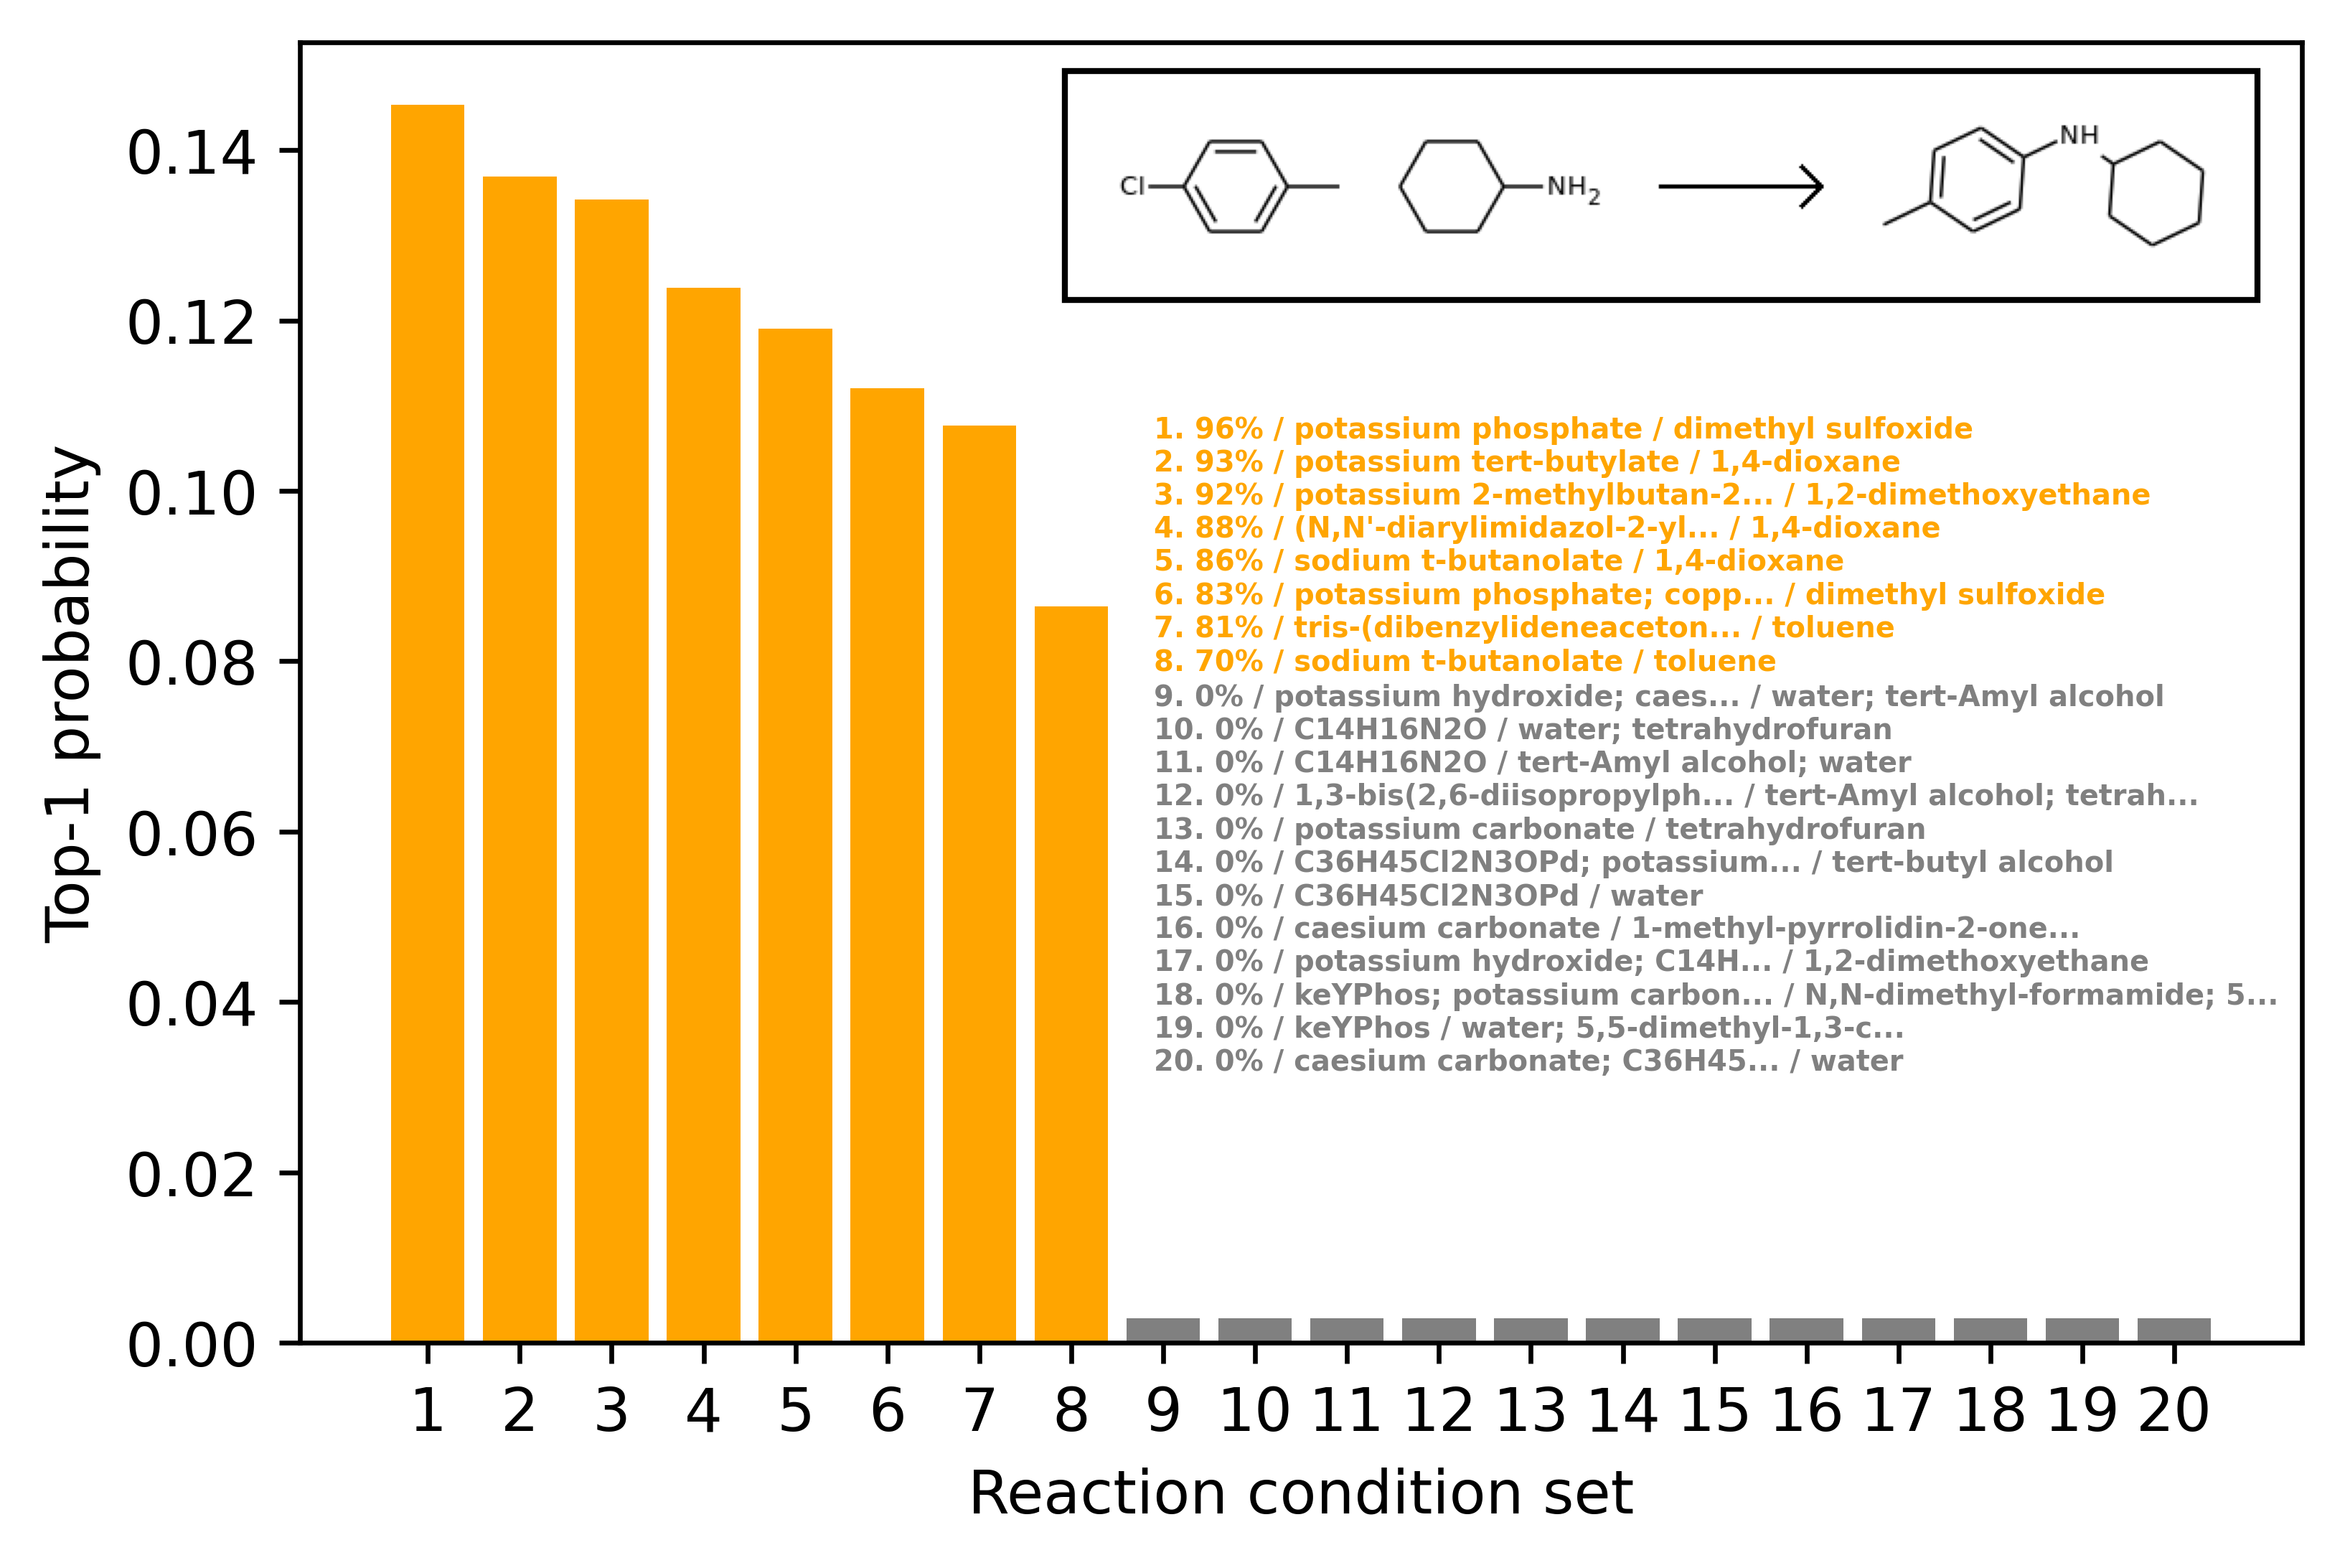

In [97]:
# 畫出轉換成relevance scores 然後exp後的distribution，機率全部相加等於1，此外，也sample false reaction conditions
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(dpi=600)

arr_img = plt.imread('reaction_id_9079015.jfif')
im = OffsetImage(arr_img, zoom=0.34)
ab = AnnotationBbox(im, (0.68, 0.89), xycoords='axes fraction')
ax.add_artist(ab)

x1 = list(range(1,num_reals + 1))
x2 = list(range(num_reals+1, len(yield_distribution) + 1))
plt.bar(x1, yield_distribution[:num_reals], color='orange')
plt.bar(x2, yield_distribution[num_reals:], color='gray')
plt.xlabel('Reaction condition set')
plt.ylabel('Top-1 probability')
plt.xticks(x1+x2)


font_real = {#'family': 'serif',
        'color':  'orange',
        'weight': 'bold',
        'size': 4.8,
        }
font_fake = {#'family': 'serif',
        'color':  'gray',
        'weight': 'bold',
        'size': 4.8,
        }
plt.text(x=8.9, y=0.064 + 0.015, s=texts_real, fontdict=font_real)
plt.text(x=8.9, y=0.017 + 0.015, s=texts_fake, fontdict=font_fake)
plt.savefig("../saved_figures/ms_figure_4_top1_probability.svg", format = "svg", bbox_inches = "tight")
# plt.legend(['Real', 'Sampled fake'])